# Hydrological Modeling 

In [1]:
from collections import OrderedDict

import contextily as ctx
import numpy as np
import pandas as pd
import psutil
import pygmo as pg
from hymod import HYMOD, compute_kge

import pydaymet as daymet
from pygeohydro import NWIS
from pynhd import NLDI

We use HyRiver packages to get the required input data for hydrological modeling of a watershed. We use [PyDaymet](https://github.com/cheginit/pydaymet) to get precipitation and potential evapotranspiration and [PyGeoHydro](https://github.com/cheginit/pygeohydro) to get streamflow observations. Then, we use an implementation of the [HYMOD](https://piahs.copernicus.org/articles/368/180/2015/piahs-368-180-2015.pdf) model for our watershed analysis. The source for the model can be found in [hymod.py](https://github.com/cheginit/HyRiver-examples/blob/main/notebooks/hymod.py) file.

For this tutorial, we select the Brays Bayou watershed in Houston, TX. There is a NWIS station in this watershed (`USGS-08075000`) that has streamflow observation data for more than 10 years (2003-2013).

We start by getting the watershed drainage area geometry using [PyNHD](https://github.com/cheginit/pynhd) and station information using [PyGeoHydro](https://github.com/cheginit/pygeohydro). Since the station is not located at the outlet of the watershed, we set `split_catchment` flag to `True` to split the catchment at the station's location.

In [2]:
station = "08075000"
dates = ("2003-01-01", "2012-12-31")
nwis = NWIS()

basin = NLDI().get_basins(station, split_catchment=True)
info = nwis.get_info({"site": station})
info

,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,alt_datum_cd,huc_cd,drain_sqkm,hcdn_2009,geometry
0,USGS,08075000,"Brays Bayou at Houston, TX",ST,29.697175,-95.412162,F,NAD83,0.0,0.01,NAVD88,12040104,261.5814,False,POINT (-95.41216 29.69717)


Let's check the area of the watershed and plot it.

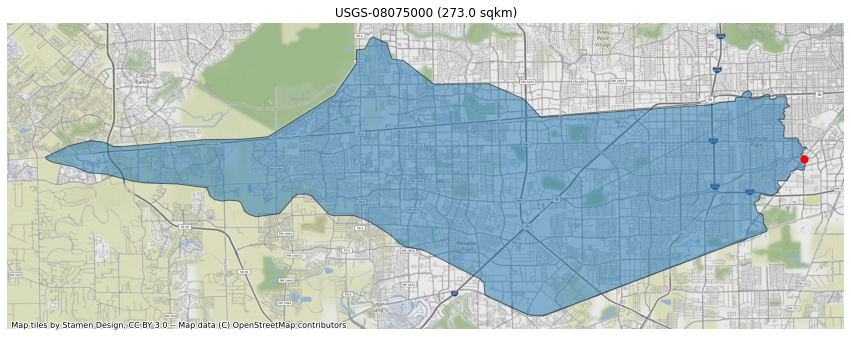

In [3]:
area_sqm = basin.to_crs(basin.estimate_utm_crs()).area.values[0]
ax = basin.plot(figsize=(15, 10), alpha=0.5, edgecolor="black")
info.plot(ax=ax, markersize=50, color="red")
ax.set_title(f"USGS-{station} ({area_sqm * 1e-6:.1f} sqkm)")
ctx.add_basemap(ax, crs=basin.crs)
ax.margins(0)
ax.set_axis_off()

Now, we get some information about this station and then retrieve streamflow observations within the period of our study for calibrating the model from PyGeoHydro. Since HYMOD's output is in mm/day we can either set the `mmd` flag of `NWIS.get_streamflow` to `True` to return the data in mm/day instead of the default cms, or use `area_sqm` that we obtained previously to do the conversion. Note that these two methods might not return identical results since `NWIS.get_streamflow` uses GagesII and NWIS to get the drainage area while here we used NLDI to obtain the area and these two are not always the same.

In [4]:
qobs = nwis.get_streamflow(station, dates)
qobs = qobs * (1000.0 * 24.0 * 3600.0) / area_sqm

We can check the difference in areas produced by these two methods as follows:

In [5]:
area_nwis = nwis._drainage_area_sqm(info, "dv")
f"NWIS: {area_nwis.iloc[0] * 1e-6:.1f} sqkm, NLDI: {area_sqm * 1e-6:.1f} sqkm"

'NWIS: 261.6 sqkm, NLDI: 273.0 sqkm'

PyDaymet can compute Potential EvapoTranspiration (PET) at daily timescale using three methods: `penman_monteith`, `priestley_taylor`, and `hargreaves_samani`. Let's use `hargreaves_samani` and get the data for our study period.

In [6]:
clm = daymet.get_bygeom(basin.geometry[0], dates, variables="prcp", pet="hargreaves_samani")

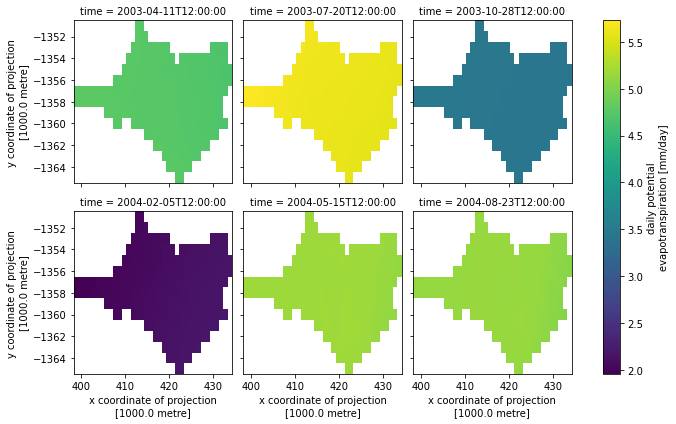

In [7]:
_ = (
    clm.where(clm.pet > 0)
    .pet.isel(time=range(100, 700, 100))
    .plot(x="x", y="y", row="time", col_wrap=3)
)

Since our HYMOD implementation is a lumped model, we need to take the areal average of the input precipitation and potential evapotranspiration data. Moreover, since Daymet's calendar doesn't have leap years (365-day year), we need to make sure that the time index of the input streamflow observation matches that of the climate data.

In [8]:
clm_df = clm.mean(dim=["x", "y"]).to_dataframe()[["prcp", "pet"]]
clm_df.index = pd.to_datetime(clm_df.index.date)

qobs.index = pd.to_datetime(qobs.index.to_series().dt.tz_localize(None).dt.date)
idx = qobs.index.intersection(clm_df.index)
qobs, clm_df = qobs.loc[idx], clm_df.loc[idx]

Now, let's use [pygmo](https://esa.github.io/pygmo2/index.html) to calibrate the model parameters using 70% of the observation data and Kling-Gupta Efficiency as objective function.

In [9]:
param_bounds = OrderedDict(
    [
        ("c_max", (1, 100)),  # Maximum storage capacity
        ("b_exp", (0.0, 2)),  # Degree of spatial variability of the soil moisture capacity
        ("alpha", (0.2, 0.99)),  # Factor for dividing flow to slow and quick releases
        ("k_s", (0.01, 0.5)),  # Residence time of the slow release reservoir
        ("k_q", (0.5, 1.2)),  # Residence time of the quick release reservoir
    ]
)
warm_up = 1  # year
cal_idx = int(0.7 * clm_df.shape[0])  # 70% of data for calibration
bounds = list(zip(*param_bounds.values()))

udp = HYMOD(clm_df.iloc[:cal_idx], qobs.iloc[:cal_idx], bounds, 1)
prob = pg.problem(udp)
n_procs = psutil.cpu_count(logical=False)
pop_size = 1000
algo = pg.algorithm(pg.sade(gen=int(pop_size / n_procs)))
archi = pg.archipelago(
    n=n_procs,
    algo=algo,
    prob=prob,
    pop_size=pop_size,
)
archi.evolve()
archi.wait_check()
_, vectors, fits = zip(*archi.get_migrants_db())
params = vectors[np.argmin(fits)].squeeze()
dict(zip(param_bounds, params))

{'c_max': 19.022301450548646,
 'b_exp': 1.9996427290149237,
 'alpha': 0.9867340700807876,
 'k_s': 0.010048422855588962,
 'k_q': 0.7490491923818765}

With the obtained calibrated parameters, we can validate the model over the validation period (30%) of the streamflow observation.

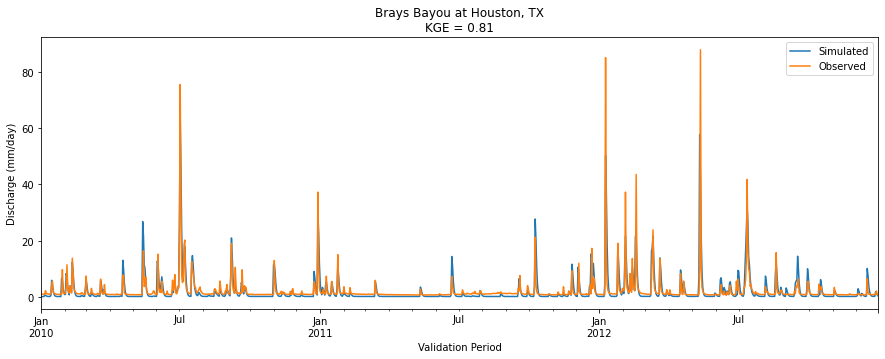

In [10]:
sim = udp.simulate(*clm_df.iloc[cal_idx:].to_numpy("f8").T, *tuple(params))
obs = qobs.iloc[cal_idx:][f"USGS-{station}"].to_numpy()
kge = compute_kge(obs, sim)
name = info.station_nm.values[0]
index = qobs.iloc[cal_idx:].index
discharge = pd.DataFrame({"Simulated": sim, "Observed": obs}, index=index)
_ = discharge.plot(
    figsize=(15, 5),
    xlabel="Validation Period",
    ylabel="Discharge (mm/day)",
    title=f"{name}\nKGE = {kge:.2f}",
)